# Sales forecasting

The project is mainly to predict the future sales by using the time-series forecasting technique. 

# Import Dependencies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Datasets 

In [2]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transaction_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holiday_event_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

# Understanding the Data

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [7]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
holiday_event_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
#The sales column is the target variable. 


##  Merging datasets holiday_event_df, stores_df, oil_df & train_df

In [10]:
train_df = train_df.merge(stores_df, on ='store_nbr')
train_df = train_df.merge(oil_df, on ='date', how='left')
holiday_event_df = holiday_event_df.rename(columns={'type': 'holiday_type'})
train_df = train_df.merge(holiday_event_df, on='date', how='left')

In [11]:
train_df.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   object 
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB


# Missing Values Detection

In [13]:
train_df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [14]:
#percentage of missing values in train_df 

missing_percentages = train_df.isnull().sum()/ len(train_df) * 100 

print(missing_percentages)

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
city             0.000000
state            0.000000
type             0.000000
cluster          0.000000
dcoilwtico      31.271879
holiday_type    83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
dtype: float64


In [15]:
# remove columns that are having more than 30% missing values

columns_to_delete = missing_percentages[missing_percentages > 30].index

train_df = train_df.drop(columns=columns_to_delete)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   type         object 
 9   cluster      int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 256.3+ MB


# Duplicates


In [17]:
train_df.duplicated().any()

True

In [18]:
dupes=train_df.duplicated()

#dupes
sum(dupes)

53460

In [19]:
#dropping duplicate values

train_df = train_df.drop_duplicates()
train_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6


In [20]:
train_df.duplicated().any()

False

In [21]:
test_df.duplicated().any()

False

# Check if there still any missing values present in the train_df


In [22]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

# Calculate count, mean, std, min, 25%, 50%, 75%, max values for each column. Prepare an analysis of the difference between mean and median for each column and possible reasons for the same.

In [23]:
train_df.describe()

,id,store_nbr,sales,onpromotion,cluster
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01


# EDA 

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3054347
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   city         object 
 7   state        object 
 8   type         object 
 9   cluster      int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 251.8+ MB


## Questions

1. Does the type of stores affect the store sales? 

2. Which family is having the highest sales? 

3. Does promotion able to improve the sales? 

4. Which city is having the most number of customers? 

5. Which state is having the most number of customers? 

6. Which of the stores has the highest sales. 

7. Which month is having the most sales, and least sales. 



### 1. Does the type of stores affect the store sales?

To answer the first question 'Does the type of stores affect the store sales?' , i will use ANOVA test. 
ANOVA (Analysis of Variance) is a statistical test used to determine whether there are significant differences between the means of two or more groups. It compares the variation between the groups (due to the different categories or factors) to the variation within the groups.


H0 (>0.05)= The type of stores does not affect store sales. There is no significant difference in store sales between different types of stores.

H1 (<0.05)= The type of stores does affect store sales. There is a significant difference in store sales between different types of stores.



In [25]:
grouped_data = train_df.groupby('type')['sales']

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(*[grouped_data.get_group(type) for type in grouped_data.groups])

# Print the results
print("F-Statistic:", f_statistic)
print("p-value:", p_value)


F-Statistic: 17766.023730362205
p-value: 0.0


Based on the F-statistics and p-value above, we reject null hypothesis and accept alternative hypothesis. Hence, the type of stores does affect the store sales. There is a significant difference in store sales between different type. 

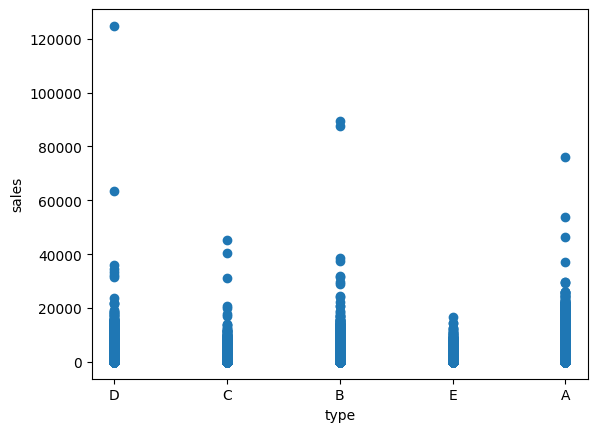

In [26]:
# Sales Vs Type

plt.scatter(train_df['type'], train_df['sales'])

plt.ylabel('sales')
plt.xlabel('type')

plt.show()
     

### 2. Which family is having the highest sales?

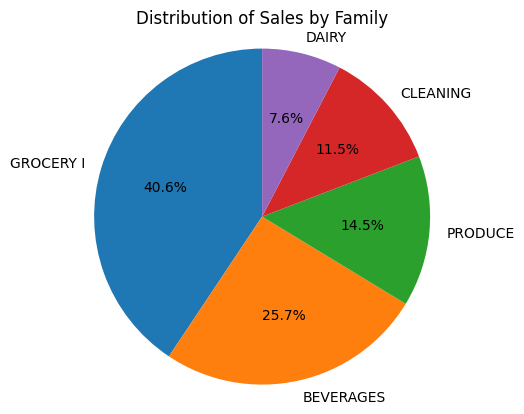

In [27]:
#Pie chart

# Group the data by family and calculate the total sales for each family
family_sales = train_df.groupby('family')['sales'].sum()

# Sort the families based on sales in descending order
family_sales_sorted = family_sales.sort_values(ascending=False)

# Get the top 5 families with the highest sales
top_families = family_sales_sorted.head(5)

# Create the pie chart
plt.pie(top_families, labels=top_families.index, autopct='%1.1f%%', startangle=90)

plt.title('Distribution of Sales by Family')

plt.axis('equal')  
plt.show()

Based on the pie chart above, the GROCERY I is having the highest sales, and Baverages comes second highest. 

### 3. Does promotion able to improve the sales?

To answer the 3rd question "Does promotion able to improve the sales?" I will use Pearson correlation test to determine the relationship between the two variables, as both of the variables are numericals. The Pearson correlation coefficient measures the linear relationship between two continuous variables and ranges from -1 to +1.

H0 (>0.05)= The promotion does not affect store sales. 

H1 (<0.05)= The promotion does affect store sales. 


In [28]:
correlation, p_value = pearsonr(train_df['onpromotion'], train_df['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.42792320481209284
p-value: 0.0


Based on the Pearson correlation coefficient of 0.4279 and the p-value of 0.0, we can reject the null hypothesis (H0) and conclude that there is a significant relationship between promotion and store sales. Therefore, the promotion does affect store sales.

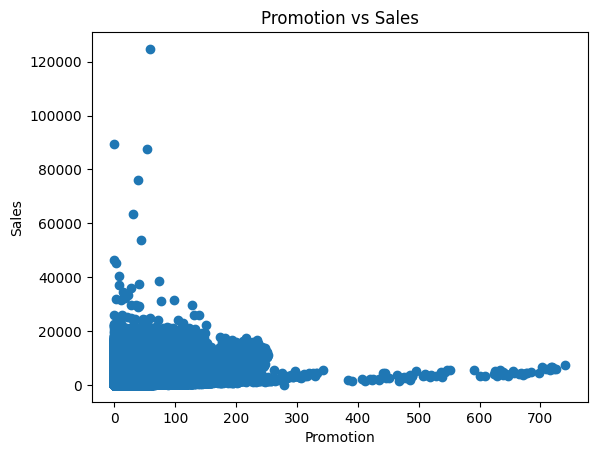

In [29]:
# Scatter plot
plt.scatter(train_df['onpromotion'], train_df['sales'])

plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.title('Promotion vs Sales')

plt.show()


### 4. Which city is having the most most number of customers?

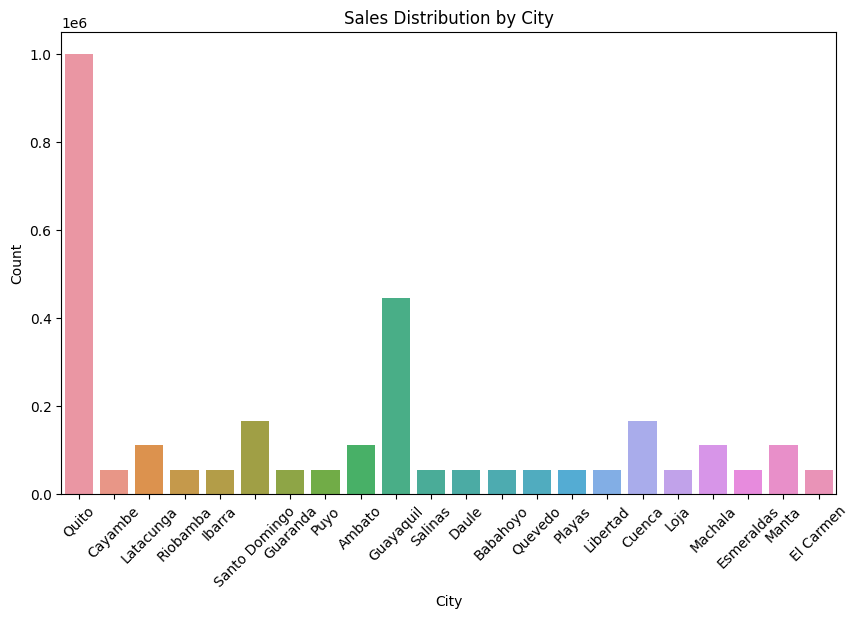

In [30]:
#Count Plot 

# Create a count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(data=train_df, x='city')

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Sales Distribution by City')

plt.xticks(rotation=45)

plt.show()


Based on the count plot above, the Quito city has the most sales. 

### 5. Which state is having the most number of customers?


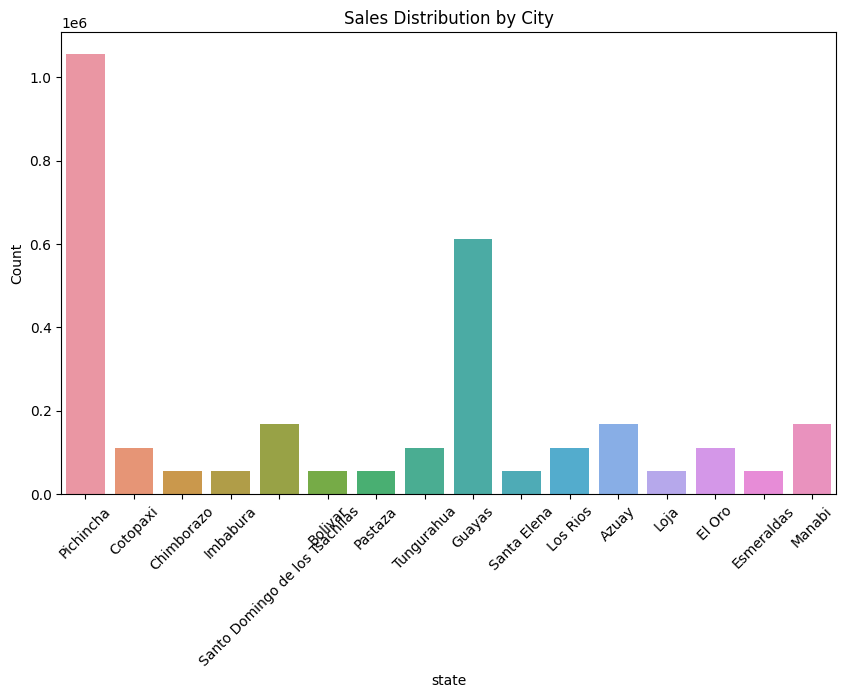

In [31]:
#Count Plot 

# Create a count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(data=train_df, x='state')

plt.xlabel('state')
plt.ylabel('Count')
plt.title('Sales Distribution by City')

plt.xticks(rotation=45)

plt.show()

Based on the count plot above, Pichincha state has the most sales as compared to other states. 

### 6. Which of the stores has the highest sales. 

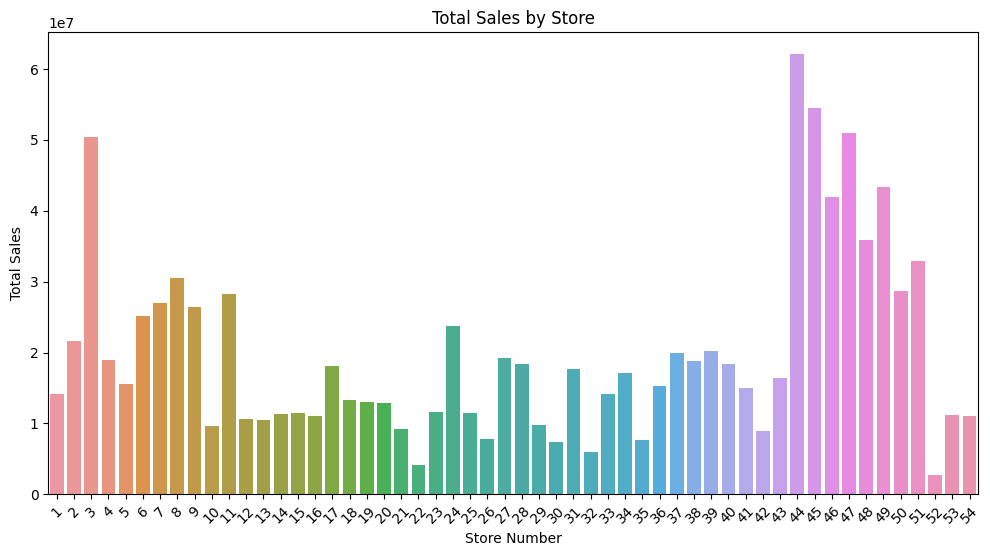

In [32]:
# Calculate the total sales for each store
store_sales = train_df.groupby('store_nbr')['sales'].sum().reset_index()

# Sort the stores based on sales in descending order
store_sales = store_sales.sort_values('sales', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=store_sales, x='store_nbr', y='sales')

plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')

plt.xticks(rotation=45)

plt.show()



### 7. Which month is having the most sales, and least sales. 

In [33]:
#First convert the 'date' from object to date time 

train_df['date']= pd.to_datetime(train_df['date'])


# create new columns 'month' 'year'
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

In [34]:
train_df.head(7)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1,2013
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,Quito,Pichincha,D,13,1,2013
6,6,2013-01-01,1,CELEBRATION,0.0,0,Quito,Pichincha,D,13,1,2013


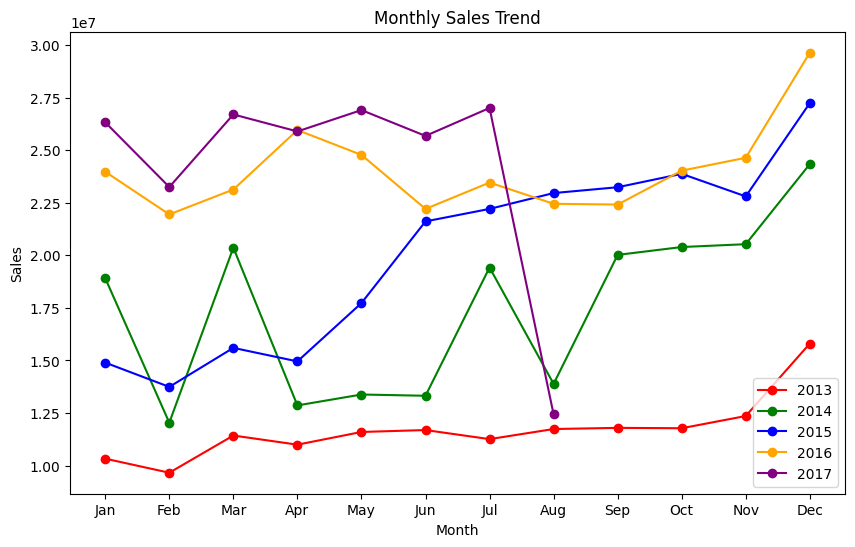

In [35]:
# Group the data by month, year, and calculate the total sales
monthly_sales = train_df.groupby(['month', 'year'])['sales'].sum().reset_index()

# Create the line chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Get unique years and cycle through colors
years = monthly_sales['year'].unique()
colors = itertools.cycle(['red', 'green', 'blue', 'orange', 'purple'])

for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', color=next(colors), label=str(year))

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')

# Customize x-axis ticks to show month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)


plt.legend()

plt.show()


Overall, the orange line which is 2016 has a stable high sales since January to Dec. Between the months in 2016, December had the most sales. In other hand, in comparing to other years, 2013 had an overall lowest sales achieved, especially during February. 

In [36]:
train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()
print(train_df)

/tmp/ipykernel_21/3055341551.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_df = train_df.groupby('date')['sales','onpromotion'].sum().reset_index()


           date          sales  onpromotion
0    2013-01-01    2511.618999            0
1    2013-01-02  496092.417944            0
2    2013-01-03  361461.231124            0
3    2013-01-04  354459.677093            0
4    2013-01-05  477350.121229            0
...         ...            ...          ...
1679 2017-08-11  826373.722022        14179
1680 2017-08-12  792630.535079         8312
1681 2017-08-13  865639.677471         9283
1682 2017-08-14  760922.406081         8043
1683 2017-08-15  762661.935939        10605

[1684 rows x 3 columns]


# Autocorrelation 

Autocorrelation measures the correlation between a time series and its lagged values. Autocorrelation plots (ACF) and partial autocorrelation plots (PACF) help identify significant lag values and potential autoregressive or moving average components.

- If the autocorrelation value is close to 1 or -1, it indicates a strong positive or negative autocorrelation, respectively.

- If the autocorrelation value is close to 0, it indicates a weak or no autocorrelation.

In [37]:
sales_series = train_df['sales']
autocorr_values = sales_series.autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.7668836879523089


Based on the result above, since the autocorrelation value is close to 1 (0.766), it suggests that there is a positive autocorrelation. A positive autocorrelation indicates that there is a relationship between the current sales values and the previous sales values.

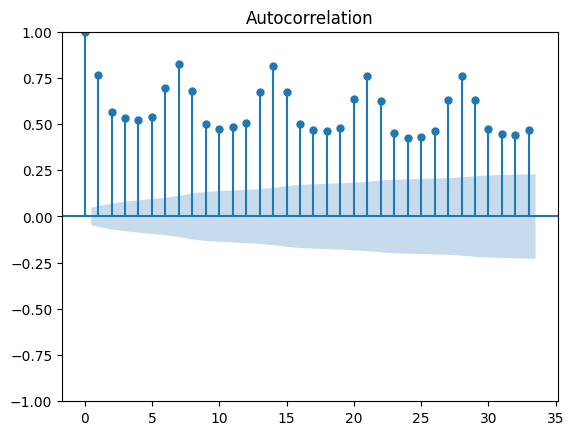

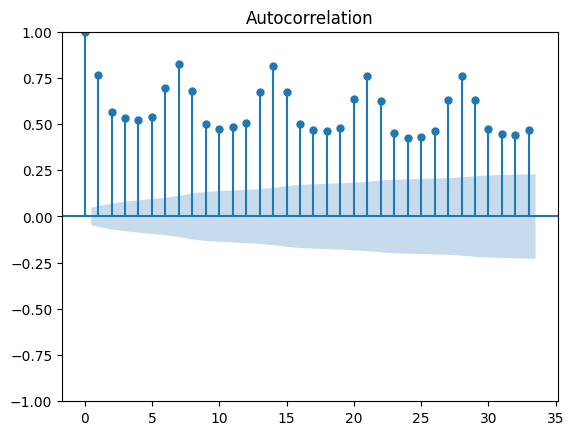

In [38]:
plot_acf(train_df['sales'])

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


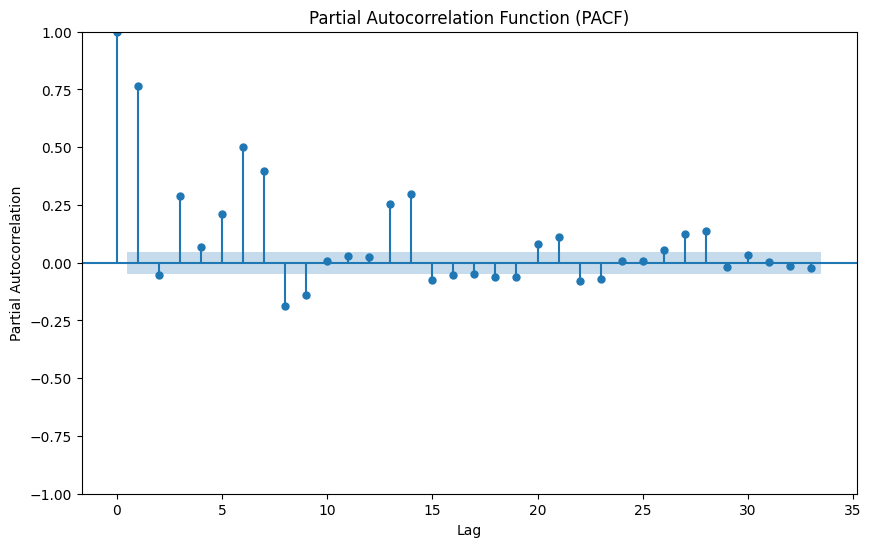

In [39]:
# Plot the PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train_df['sales'], ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

# Differencing technique 

This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data. 

In [40]:
train_df['diff_sales'] = train_df['sales'].diff()

In [41]:
train_df = train_df.dropna()

In [42]:
print(train_df['diff_sales'])

1       493580.798945
2      -134631.186820
3        -7001.554031
4       122890.444136
5        42345.279859
            ...      
1679    174986.810052
1680    -33743.186943
1681     73009.142392
1682   -104717.271390
1683      1739.529858
Name: diff_sales, Length: 1683, dtype: float64


In [43]:
train_df['diff_sales'] = train_df['sales'] - train_df['sales'].shift(1)

In [44]:
# Drop the first row since differencing introduces a NaN value
train_df = train_df.dropna()

In [45]:
print(train_df['diff_sales'])

2      -134631.186820
3        -7001.554031
4       122890.444136
5        42345.279859
6      -183572.600022
            ...      
1679    174986.810052
1680    -33743.186943
1681     73009.142392
1682   -104717.271390
1683      1739.529858
Name: diff_sales, Length: 1682, dtype: float64


In [46]:
train_df.head()

,date,sales,onpromotion,diff_sales
2,2013-01-03,361461.231124,0,-134631.186820
3,2013-01-04,354459.677093,0,-7001.554031
4,2013-01-05,477350.121229,0,122890.444136
5,2013-01-06,519695.401088,0,42345.279859
6,2013-01-07,336122.801066,0,-183572.600022


/tmp/ipykernel_21/1776887728.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)


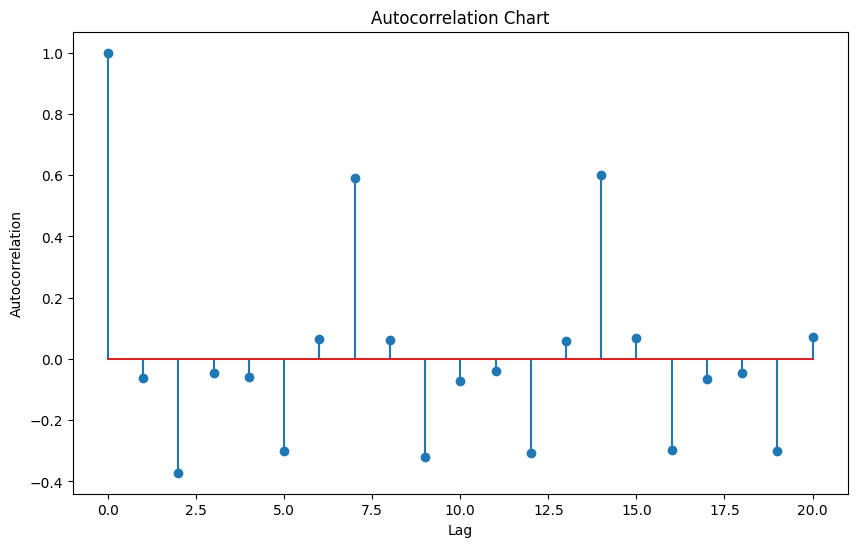

In [47]:
# Compute the autocorrelation
autocorrelation = sm.tsa.acf(train_df['diff_sales'], nlags=20)

# Plot the autocorrelation chart
plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

# Stationarity Test 


There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

### Augmented Dickey-Fuller (ADF)  test 

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [48]:
ts = train_df['diff_sales']

In [49]:
# Perform the ADF test
result = adfuller(ts)

# Extract and print the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -11.49467918718879
p-value: 4.645171054102166e-21


The ADF statistic is -11.494679187188824. This statistic is a negative value and is more negative than the critical values at common significance levels. This suggests strong evidence against the null hypothesis of a unit root, indicating that the time series is stationary.

The p-value is 4.645171054101398e-21, which is a very small value close to zero. Typically, if the p-value is below a chosen significance level (e.g., 0.05), it indicates strong evidence to reject the null hypothesis. In your case, the extremely small p-value suggests strong evidence against the presence of a unit root and supports the stationarity of the time series.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is another statistical test used to assess the stationarity of a time series. It is complementary to the Augmented Dickey-Fuller (ADF) test.

The KPSS test evaluates the null hypothesis that the time series is stationary against the alternative hypothesis of non-stationarity. Unlike the ADF test, which assumes the presence of a unit root, the KPSS test assumes the absence of a unit root.

The test calculates the KPSS statistic, which measures the cumulative sum of squared deviations from the mean in the series. It also provides a p-value that indicates the probability of observing the KPSS statistic or a more extreme value under the null hypothesis.

Interpreting the results of the KPSS test involves considering the KPSS statistic and the associated p-value. If the KPSS statistic is greater than the critical value at a chosen significance level (e.g., 0.05), it provides evidence against the null hypothesis of stationarity. Conversely, if the KPSS statistic is smaller than the critical value, it suggests that the time series is stationary.

In [50]:
result = kpss(ts)

# Extract and print the test statistic and p-value
kpss_statistic = result[0]
p_value = result[1]
print("KPSS Statistic:", kpss_statistic)
print("p-value:", p_value)

KPSS Statistic: 0.026854877460035127
p-value: 0.1


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The KPSS statistic is 0.02685487746003539. This statistic measures the discrepancy between the observed series and the series' trend. It indicates how far the series deviates from stationarity. A smaller KPSS statistic suggests a closer fit to stationarity.

The p-value is 0.1, which is equal to the chosen significance level of 0.1. Typically, if the p-value is greater than the significance level, it suggests that there is insufficient evidence to reject the null hypothesis of stationarity. Based on the result, the p-value is equal to the significance level, indicating that the results are inconclusive.

# Final ACF & PACF 

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


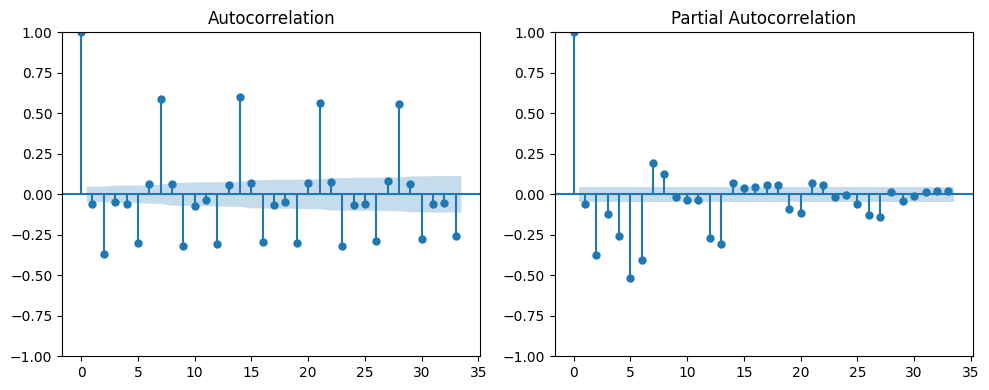

In [51]:
# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(train_df['diff_sales'], ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
ax2 = plt.subplot(122)
plot_pacf(train_df['diff_sales'], ax=ax2)

plt.tight_layout()
plt.show()

# Autoregressive Integrated Moving Average Model (ARIMA) model

In [52]:
p = 2

d = 1 

q = 1

In [53]:
train_np = train_df['diff_sales'].values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

result = model.fit()

In [54]:
# Print the model summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1682
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -22466.312
Date:                Sun, 14 May 2023   AIC                          44940.623
Time:                        10:14:32   BIC                          44962.332
Sample:                             0   HQIC                         44948.664
                               - 1682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0844      0.024     -3.459      0.001      -0.132      -0.037
ar.L2         -0.3759      0.027    -14.179      0.000      -0.428      -0.324
ma.L1         -0.9992      0.036    -27.920      0.0

In [55]:
# Make predictions
start_idx = len(train_np)
end_idx = len(train_np) + len(test_df) - 1
predictions = result.predict(start=start_idx, end=end_idx)

# Print the predictions
print(predictions)

[ 39458.28697651  -3743.29116372 -14277.55293312 ...    164.19246274
    164.19246274    164.19246274]


In [56]:
actual_values = train_df['diff_sales']

In [57]:
# Truncate or pad the predictions array to match the length of actual_values
predictions = predictions[:len(actual_values)]

# Calculate evaluation metrics
mae = np.mean(np.abs(predictions - actual_values))
mse = np.mean((predictions - actual_values) ** 2)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 116113.50315596268
Mean Squared Error (MSE): 25441765312.49467
Root Mean Squared Error (RMSE): 159504.7501251755


# Submission 



In [58]:
submission = pd.DataFrame()
submission['id'] = test_df['id'] 
submission['sales'] = np.zeros(len(test_df))

# save the submission file as a CSV file
submission.to_csv('mysubmission.csv', index=False)